In [87]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from scipy.sparse import dok_matrix
import torch

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 匯入training data

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
file_path = '/content/drive/My Drive/rcv1.txt'

labels = []
rows, cols, target = [], [], []
max_index = 0

try:
    with open(file_path, 'r') as f:
        for row_index, line in enumerate(f):
            parts = line.strip().split()

            labels.append(int(parts[0]))
            #print(int(parts[0]))

            for item in parts[1:]:
                index, value = item.split(':')
                index = int(index)
                value = float(value)
                rows.append(row_index)
                cols.append(index)
                target.append(value)
                max_index = max(max_index, index)
            if row_index == 1999:
                break

    n_samples = len(labels)
    n_features = max_index + 1
    sparse_matrix = dok_matrix((n_samples, n_features), dtype=np.float32)

    for r, c, v in zip(rows, cols, target):
        sparse_matrix[r, c] = v

    print(f'# of samples:  {n_samples}, # of features: {n_features}' )


except Exception as e:
    print('Loading file error : ', e)

print(labels)


# of samples:  2000, # of features: 47225
[1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1,

# Hyper Parameters

In [91]:
LR_SARAH = 0.1
LR_SVRG = 0.1
LR_SGD = 0.1
lambda_reg = 1 / n_samples

In [92]:
def sparse_times_dense(x, w):
    indices = x._indices()  # 稀疏張量的索引
    values = x._values()  # 稀疏張量的值

    result = 0


    for i in range(values.shape[0]):
        result += w[indices[0][i]] * values[i]

    # print(result)
    return result

# 計算Gradient, Loss

In [93]:
def logistic_loss(X, w, y):
    loss = torch.zeros(1).to(device)
    for xi, yi in zip(X, y):
        z = sparse_times_dense(xi, w)
        loss += torch.log(1 + torch.exp(-yi * z))
    return loss / n_samples + (lambda_reg / 2) * torch.sum(w ** 2)


def single_gradient(x, w, y):
    z = sparse_times_dense(x, w)  # 單樣本的預測值

    exp_term = torch.exp(y * z)

    grad_data_loss = (-y.item() * x) / (1 + exp_term.item())
    #print((1 + exp_term.item()))

    grad_reg = lambda_reg * w
    # print(grad_reg + grad_data_loss)
    return grad_reg + grad_data_loss

def full_gradient(X, w, y):
    grad_data_loss = torch.zeros(n_features).to(device)
    for xi, yi in zip(X, y):
        z = sparse_times_dense(xi, w)
        exp_term = torch.exp(yi * z)
        grad_data_loss += (-yi.item() * xi) / (1 + exp_term.item())

    grad_reg = lambda_reg * w
    return grad_data_loss / n_samples + grad_reg

# full_gradient(X_train, w_init, y_train)

In [94]:
w_init = np.zeros(n_features)
w_init = torch.tensor(w_init, dtype = torch.float32).to(device)
losses = []
effective_passes = []
total_passes = 0
out_iter = 10
inner_iter = 250
X_train = sparse_matrix
y_train = labels
coo = sparse_matrix.tocoo()

values = torch.tensor(coo.data, dtype=torch.float32)  # 非零值
indices = torch.tensor([coo.row, coo.col], dtype=torch.int64)  # 行列索引
X_train = torch.sparse_coo_tensor(indices, values, coo.shape).to(device)

y_train = torch.tensor(y_train, dtype = torch.float32).to(device)

print(y_train.shape)

torch.Size([2000])


In [95]:
torch.cuda.empty_cache()

# SARAH

In [97]:
print(logistic_loss(X_train, w_init, y_train))
for s in range(out_iter):
    w_0 = w_init.clone()
    v_0 = full_gradient(X_train, w_0, y_train)
    print(torch.norm(v_0))
    w_1 = w_0 - LR_SARAH * v_0
    losses.append(logistic_loss(X_train, w_1, y_train))
    total_passes += 1
    effective_passes.append(total_passes)
    idx = np.random.randint(0, inner_iter)
    for t in range(inner_iter):
        i = np.random.randint(0, n_samples)
        v_0 = single_gradient(X_train[i], w_1, y_train[i]) - single_gradient(X_train[i], w_0, y_train[i]) + v_0
        w_0 = w_1.clone()
        w_1 = w_1 - LR_SARAH * v_0
        if t == idx:
            w_init = w_1.clone()
        total_passes += 2 / n_samples
        if(t % 50 == 0):
            losses.append(logistic_loss(X_train, w_1, y_train))
            effective_passes.append(total_passes)



tensor([0.6931], device='cuda:0')
tensor(0.0354, device='cuda:0')
tensor(0.0339, device='cuda:0')
tensor(0.0338, device='cuda:0')
tensor(0.0330, device='cuda:0')
tensor(0.0318, device='cuda:0')
tensor(0.0302, device='cuda:0')
tensor(0.0283, device='cuda:0')
tensor(0.0282, device='cuda:0')
tensor(0.0273, device='cuda:0')
tensor(0.0262, device='cuda:0')


In [98]:
print(losses)
losses = [t.cpu().tolist() for t in losses]

[tensor([0.6930], device='cuda:0'), tensor([0.6929], device='cuda:0'), tensor([0.6867], device='cuda:0'), tensor([0.6807], device='cuda:0'), tensor([0.6749], device='cuda:0'), tensor([0.6693], device='cuda:0'), tensor([0.6763], device='cuda:0'), tensor([0.6762], device='cuda:0'), tensor([0.6705], device='cuda:0'), tensor([0.6650], device='cuda:0'), tensor([0.6596], device='cuda:0'), tensor([0.6544], device='cuda:0'), tensor([0.6747], device='cuda:0'), tensor([0.6746], device='cuda:0'), tensor([0.6689], device='cuda:0'), tensor([0.6635], device='cuda:0'), tensor([0.6581], device='cuda:0'), tensor([0.6530], device='cuda:0'), tensor([0.6655], device='cuda:0'), tensor([0.6654], device='cuda:0'), tensor([0.6601], device='cuda:0'), tensor([0.6549], device='cuda:0'), tensor([0.6498], device='cuda:0'), tensor([0.6449], device='cuda:0'), tensor([0.6524], device='cuda:0'), tensor([0.6523], device='cuda:0'), tensor([0.6473], device='cuda:0'), tensor([0.6424], device='cuda:0'), tensor([0.6377], de

# SVRG

In [112]:
w_tilde = np.zeros(n_features)
w_tilde = torch.tensor(w_tilde, dtype = torch.float32).to(device)
losses_SVRG = []
effective_passes_SVRG = []
total_passes = 0
next_w_tilde = w_tilde

In [113]:
for s in range(out_iter):
    w_tilde = next_w_tilde.clone()
    w_0 = w_tilde.clone()

    mu_tilde = full_gradient(X_train, w_tilde, y_train)
    print(torch.norm(mu_tilde))

    losses_SVRG.append(logistic_loss(X_train, w_tilde, y_train))
    total_passes += 1
    effective_passes_SVRG.append(total_passes)
    idx = np.random.randint(0, inner_iter)
    for t in range(inner_iter):
        i = np.random.randint(0, n_samples)
        v_t = single_gradient(X_train[i], w_0, y_train[i]) - single_gradient(X_train[i], w_tilde, y_train[i]) + mu_tilde
        w_1 = w_0 - LR_SVRG * v_t

        w_0 = w_1.clone()
        if t == idx:
          next_w_tilde = w_1.clone()
        total_passes += 2 / n_samples
        if t % 50 == 0:

            losses_SVRG.append(logistic_loss(X_train, w_1, y_train))
            effective_passes_SVRG.append(total_passes)


tensor(0.0354, device='cuda:0')
tensor(0.0336, device='cuda:0')
tensor(0.0320, device='cuda:0')
tensor(0.0317, device='cuda:0')
tensor(0.0304, device='cuda:0')
tensor(0.0295, device='cuda:0')
tensor(0.0293, device='cuda:0')
tensor(0.0288, device='cuda:0')
tensor(0.0280, device='cuda:0')
tensor(0.0265, device='cuda:0')


In [114]:
losses_SVRG = [t.cpu().tolist() for t in losses_SVRG]

In [115]:
optimal_loss = min(losses)
optimal_loss = min(optimal_loss, min(losses_SVRG))
print(optimal_loss)

[0.5768644213676453]


In [116]:
loss_residuals_SVRG = [loss[0] - optimal_loss[0] for loss in losses_SVRG]

In [117]:
loss_residuals = [loss[0] - optimal_loss[0] for loss in losses]

# Plot

60


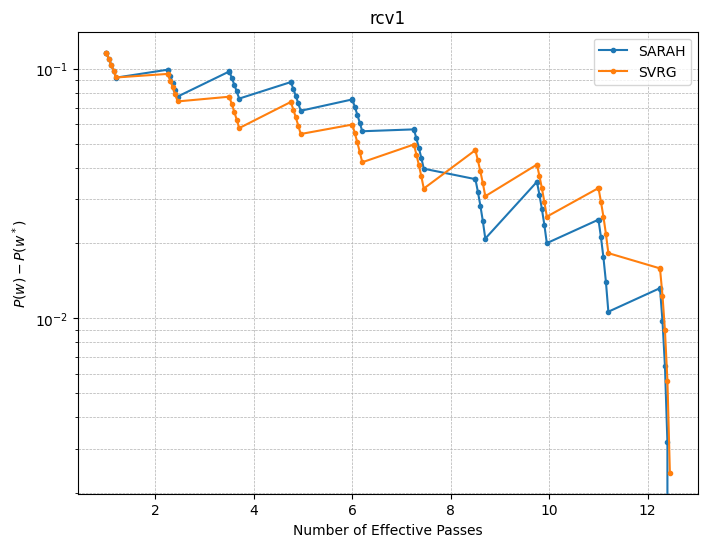

In [118]:
plt.figure(figsize=(8, 6))
plt.plot(effective_passes, loss_residuals, label="SARAH", marker="o", markersize=3)
print(len(effective_passes_SVRG))
plt.plot(effective_passes_SVRG, loss_residuals_SVRG, label="SVRG", marker='o', markersize=3)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("Number of Effective Passes")
plt.ylabel("$P(w) - P(w^*)$")
plt.title("rcv1")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig('/content/loss_residuals.png')
plt.show()

In [108]:
for i in range(len(losses_SVRG)):
  if i == 0:
    print(losses_SVRG[i])
  elif effective_passes_SVRG[i] - effective_passes_SVRG[i-1] == 1:
    print(losses_SVRG[i])

[0.6944041848182678]


# SGD

In [119]:
from google.colab import files
files.download('/content/loss_residuals.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>